## Data Preprocessing to Script
---

In [1]:
import gc, sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm import tqdm
from pandas.tseries.offsets import BDay

sys.path.insert(1, "../..")
from src.feature.utils import applyParallel, get_full_column

%load_ext autoreload
%autoreload 2

In [2]:
%time transactions_df = pd.read_parquet("../../data/joined/joined_1617834490/joined_1617834490.parquet")

existing_cols = transactions_df.columns.copy()

CPU times: user 1min 28s, sys: 2min 16s, total: 3min 45s
Wall time: 7min


In [3]:
transactions_df.head()

,trnx_tjd,tseq,trnx_time,business_account_number,trnx_created_dt,trnx_endbal,trnx_transaction_code,trnx_transaction_comment,trnx_transaction_amount,trnx_is_credit,...,socure_address_risk_score,socure_email_risk_score,socure_phone_risk_score,socure_name_address_correlation,socure_name_email_correlation,socure_name_phone_correlation,socure_social_profiles_found,socure_nr_social_profiles_found,bk_acct_rstr_last_unrestricted_date,bk_acct_rstr_first_restricted_by_risk_date
0,2017-12-13,8,16:26:31,410000007044,2017-12-13,500.00,ACHDD,CO,500.00,1,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,2021-01-12,NaT
1,2017-12-19,35,23:55:20,410000007044,2017-12-19,500.04,ACHDDIN,PAYPAL VERIFYBANK,0.04,1,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,2021-01-12,NaT
2,2017-12-19,36,23:55:20,410000007044,2017-12-19,500.14,ACHDDIN,PAYPAL VERIFYBANK,0.10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,2021-01-12,NaT
3,2017-12-19,37,23:55:20,410000007044,2017-12-19,500.24,ACHDDIN,PAYPAL VERIFYBANK,0.10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,2021-01-12,NaT
4,2017-12-19,38,23:55:20,410000007044,2017-12-19,500.26,ACHDDIN,PAYPAL VERIFYBANK,0.02,1,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,2021-01-12,NaT


(28260180, 109)

Timestamp('2021-04-07 01:27:37')

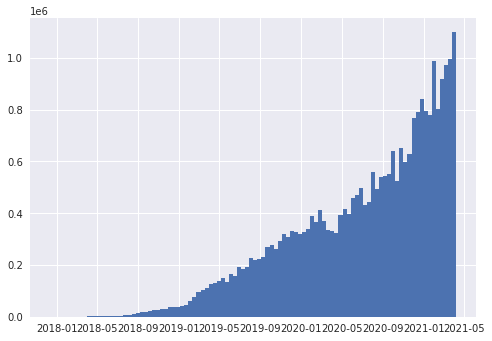

In [4]:
plt.style.use("seaborn")
display(transactions_df.shape)
transactions_df.transaction_datetime.hist(bins=100)
transactions_df.transaction_datetime.max()

### Setup Debugging
---

In [5]:
debug = False
sample = False
id_col = 'business_account_number'
id_token = "<BUSINESS_ACCOUNT_NUMBER>"
if debug:
    debug_ids = pd.read_csv('../../artifacts/debug_ids.csv')
    debug_ids[id_token] = debug_ids[id_token].astype(transactions_df[id_col].dtype)
    tdf = transactions_df[transactions_df[id_col].isin(debug_ids[id_token])]
    # load ids
    # filter by ids
# debug version: load and filter by debug_ids 
elif sample:
    tdf = transactions_df.sample(n=1000000, replace=False)
else:
    tdf = transactions_df 

In [6]:
tdf.shape

(28260180, 109)

Timestamp('2021-04-07 01:27:37')

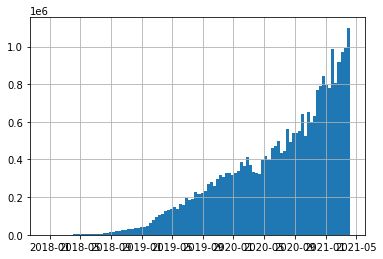

In [7]:
tdf.transaction_datetime.hist(bins=100)
tdf.transaction_datetime.max()

### Add ID
---

In [8]:
def get_transactions_id(transactions_df):
    transactions_df.sort_values(by=['business_account_number', 
                                    'transaction_datetime'],
                                inplace=True)
    transactions_df['group_rank'] = transactions_df.groupby('business_account_number')['transaction_datetime'].rank('first').astype(int)

    # get id by combining bid, datatime, and rank
    # actually need a way to order this key...
    transactions_df['transaction_id'] = (transactions_df['business_account_number'].astype(str) 
                                         + '-' + transactions_df['transaction_datetime'].apply(lambda x: str(int(x.timestamp())))
                                         + '-' + transactions_df['group_rank'].astype(str))
    return transactions_df

In [9]:
tdf = get_transactions_id(tdf)
display(tdf['transaction_id'].nunique(), tdf.shape)
tdf.transaction_id.head()

28260180

(28260180, 111)

0    410000007044-1513182391-1
1    410000007044-1513727720-2
2    410000007044-1513727720-3
3    410000007044-1513727720-4
4    410000007044-1513727720-5
Name: transaction_id, dtype: object

### Feature Transformation
---

In [10]:
# set up id and date columns
id_col = "business_account_number"
date_col = "transaction_datetime"

# sort data by id and then datetime
tdf = tdf.sort_values(by=[id_col, date_col])

#### Account Level Features

In [11]:
first_tdt = tdf.groupby(id_col)[date_col].min().rename("first_transaction_datetime").to_frame()
tdf = pd.merge(tdf, first_tdt, how="left", on=id_col)

tdf["days_since_first_deposit"] = (tdf["transaction_datetime"] - tdf["first_transaction_datetime"]).dt.days

In [12]:
tdf["age_money_account"] = (tdf["transaction_datetime"] - tdf["banking_acct_open_date"]).dt.days
tdf['lag_acc_open_first_transaction'] = (tdf['first_transaction_datetime'] - \
                                         tdf['banking_acct_open_date']).dt.days

# first_deposit_amount -> banking_first_deposit_amount

#### External Account Linkage

In [13]:
### External bank linkages
res = []
curr = None
counter = {}

for row in tqdm(tdf[['business_account_number', 'transaction_datetime', 
                     'trnx_external_account_number', 'trnx_external_institution_id', 
                     'trnx_transaction_amount']].values):
    if row[0] != curr:
        curr = row[0]
        counter = {}

    if not row[2]:
        res.append([None for i in range(6)])
        continue

    out = []

    external_account_number = row[2]

    if external_account_number not in counter:
        counter[external_account_number] = {}

    # nr past transactions with this account
    if 'nr_trans_with_acc' in counter[external_account_number]:
        counter[external_account_number]['nr_trans_with_acc'] += 1
    else:
        counter[external_account_number]['nr_trans_with_acc'] = 1
    out.append(counter[external_account_number]['nr_trans_with_acc'] - 1)

    # first transaction dt
    if 'first_transaction_dt' not in counter[external_account_number]:
        counter[external_account_number]['first_transaction_dt'] = row[1]
    out.append(counter[external_account_number]['first_transaction_dt'])

    # last transaction_dt
    if 'last_transaction_dt' not in counter[external_account_number]:
        counter[external_account_number]['last_transaction_dt'] = None
    out.append(counter[external_account_number]['last_transaction_dt'])
    counter[external_account_number]['last_transaction_dt'] = row[1]

    # sum pos/neg transactions with acct
    if 'sum_pos_trans' not in counter[external_account_number]:
        counter[external_account_number]['sum_pos_trans'] = 0
    if 'sum_neg_trans' not in counter[external_account_number]:
        counter[external_account_number]['sum_neg_trans'] = 0
    out.append(counter[external_account_number]['sum_pos_trans'])
    out.append(counter[external_account_number]['sum_neg_trans'])

    if row[4] >= 0:
        counter[external_account_number]['sum_pos_trans'] += row[4]
    else:
        counter[external_account_number]['sum_neg_trans'] += row[4]

    if 'rolling_mean_pos_trans' not in counter[external_account_number]:
        counter[external_account_number]['rolling_mean_pos_trans'] = row[4]
        out.append(None)
    else:
        out.append(counter[external_account_number]['rolling_mean_pos_trans'])
        counter[external_account_number]['rolling_mean_pos_trans'] = (counter[external_account_number]['rolling_mean_pos_trans'] + row[4]) / 2

    res.append(out)

ea_cols = ['nr_trans_with_acc', 'first_trans_with_ea_dt', 'last_trans_with_ea_dt', 'sum_pos_trans_ea', 'sum_neg_trans_ea', 'rolling_mean_pos_trans_ea']
tdf = tdf.assign(**dict.fromkeys(ea_cols, np.nan))
tdf[ea_cols] = res

del res

100%|██████████| 28260180/28260180 [00:54<00:00, 516563.73it/s]


In [14]:
# ea -> external account
tdf['time_since_first_trans_ea'] = (tdf['transaction_datetime'] - tdf['first_trans_with_ea_dt']).dt.days
tdf['time_since_last_trans_ea'] = (tdf['transaction_datetime'] - tdf['last_trans_with_ea_dt']).dt.days

tdf['ratio_all_ea_trans_div_tamt'] = tdf['sum_pos_trans_ea'] / tdf['trnx_transaction_amount']
tdf['ratio_rolling_mean_ea_tamt_div_tamt'] = tdf['rolling_mean_pos_trans_ea'] / tdf['trnx_transaction_amount']


#### Giact Features

which should not use because giact data is messy in production

In [15]:
# Giact features...which should not use because giact data is messy in production
tdf['giact_time_since_first_link'] = (tdf['transaction_datetime'] - \
                                      tdf['giact_first_link_date']).dt.days
tdf['giact_time_since_last_link'] = (tdf['transaction_datetime'] - \
                                     tdf['giact_last_link_date']).dt.days

#### Transaction Features

In [16]:
### TRANSACTION (not roll-ups) FEATURES
tdf['transaction_as_pct_of_balance'] = tdf['trnx_transaction_amount'] / \
                                       (tdf['trnx_real_ending_balance'] - \
                                        tdf['trnx_transaction_amount'])

tdf['last_transaction_datetime'] = tdf.groupby(id_col)[date_col].shift(1)

# this feature doesn't make sense... Just to keep here for record
tdf['last_transaction_code'] = tdf.groupby(id_col)['trnx_transaction_code'].shift(1)  

tdf['time_since_last_transaction'] = (tdf['transaction_datetime'] - 
                                      tdf['last_transaction_datetime']).dt.seconds # this relies on transactions we don't like not being included!

#### Transaction (roll-ups) Features
---

Features that requires more advanced techinical tricks

In [17]:
# %load_ext blackcellmagic

In [18]:
# # transaction features
deposit_transaction_codes = [
    "POSDD",
    "ACHDD",
    "ACHDDIN",
    "ACHINDD",
    "DDCK",
    "DDMBR",
    "DD",
]
withdrawal_transaction_codes = [
    "POSDW",
    "ACHDW",
    "ACHDWIN",
    "DWATM",
    "DWATMI",
    "DWCK",
    "DWBILLPAY",
    "DWCRDBILLPAY",
    "DWMBR",
    "ACHDWP2P",
    "DWWIRE",
    "DBDWWIRE",
    "DWTRF",
    "DBDW",
    "DWSLROTP",
    "DW",
]

tdf["is_return"] = tdf["trnx_transaction_code"].isin(
    ["DWCKCB", "DWACHRET", "DDACHRET"]
) | (
    (tdf["trnx_transaction_code"].isin(deposit_transaction_codes))
    & (tdf["trnx_transaction_amount"] < 0)
)
tdf["is_trans"] = tdf["trnx_transaction_code"].isin(
    deposit_transaction_codes + withdrawal_transaction_codes
)
tdf["is_deposit"] = tdf["trnx_transaction_code"].isin(deposit_transaction_codes) & (
    tdf["trnx_transaction_amount"] > 0
)

In [19]:
%%time 
tdf['nr_past_returns'] = tdf.groupby(id_col)['is_return'].cumsum()

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['is_return'].sum()
tdf['nr_returns_30d']=applyParallel(tdf.groupby(id_col), func).values

tdf['nr_past_deposits'] = tdf.groupby(id_col)['is_deposit'].cumsum()

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['is_deposit'].sum()
tdf['nr_deposits_3d']=applyParallel(tdf.groupby(id_col), func).values

CPU times: user 11min 14s, sys: 2min 42s, total: 13min 56s
Wall time: 14min 29s


In [ ]:
%%time 

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['is_deposit'].sum()
tdf['nr_deposits_30d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['is_trans'].sum()
tdf['nr_transactions_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['is_trans'].sum()
tdf['nr_transactions_30d']=applyParallel(tdf.groupby(id_col), func).values

tdf['pct_returned_deposits'] = tdf['nr_past_returns'] / tdf['nr_past_deposits']

tdf['pct_returned_deposits_30d'] = tdf['nr_returns_30d'] / tdf['nr_deposits_30d']

In [ ]:
%%time
# features cannot be parallelized that may take a while
# as it turns out cumcount/cumsum/cum* functions are incredibly efficient
tdf['nr_past_transactions'] = tdf.groupby(id_col)[id_col].cumcount()

tdf['nr_transactions_30d_div_nr_past_transactions'] = tdf['nr_transactions_30d'] / tdf['nr_past_transactions']

# features based on account balances
tdf['tamt_adjusted'] = tdf['trnx_transaction_amount'] * np.where(tdf['trnx_transaction_code'] == 'ACHDD', -1, 1)

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['trnx_real_ending_balance'].mean()
tdf['mean_account_balance_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['trnx_real_ending_balance'].mean()
tdf['mean_account_balance_30d']=applyParallel(tdf.groupby(id_col), func).values

In [ ]:
%%time

tdf['deposit_transaction_amount'] = (tdf['is_deposit'] * tdf['trnx_transaction_amount']).replace(np.nan, 0)

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['deposit_transaction_amount'].sum()
tdf['sum_deposits_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on=date_col)['deposit_transaction_amount'].sum()
tdf['sum_deposits_10d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['deposit_transaction_amount'].sum()
tdf['sum_deposits_30d']=applyParallel(tdf.groupby(id_col), func).values


tdf['is_withdrawal'] = tdf['trnx_transaction_code'].isin(withdrawal_transaction_codes) & \
                       (tdf['trnx_transaction_amount'] < 0)
tdf['withdrawal_transaction_amount'] = (tdf['is_withdrawal'] * tdf['trnx_transaction_amount']).replace(np.nan, 0)

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['withdrawal_transaction_amount'].sum()
tdf['sum_withdrawals_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on=date_col)['withdrawal_transaction_amount'].sum()
tdf['sum_withdrawals_10d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['withdrawal_transaction_amount'].sum()
tdf['sum_withdrawals_30d']=applyParallel(tdf.groupby(id_col), func).values

In [ ]:
def func(df_): return df_.rolling('10d',min_periods=1,on=date_col)['deposit_transaction_amount'].mean()
tdf['mean_deposits_10d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.expanding().mean()
tdf['mean_deposits']=applyParallel(tdf.groupby(id_col)['deposit_transaction_amount'], func).values

def func(df_): return df_.rolling('10d',min_periods=1,on=date_col)['withdrawal_transaction_amount'].mean()
tdf['mean_withdrawals_10d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.expanding().mean()
tdf['mean_withdrawals']=applyParallel(tdf.groupby(id_col)['withdrawal_transaction_amount'], func).values

tdf['mean_deposits_10d_div_mean_deposits'] = tdf['mean_deposits_10d'] / tdf['mean_deposits']
tdf['mean_withdrawals_10d_div_mean_withdrawals'] = tdf['mean_withdrawals_10d'] / tdf['mean_withdrawals']

In [ ]:
%%time

def func(df_): return df_.expanding().max()
tdf['max_deposits']=applyParallel(tdf.groupby(id_col)['deposit_transaction_amount'], func).values

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['deposit_transaction_amount'].max()
tdf['max_deposits_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on=date_col)['deposit_transaction_amount'].max()
tdf['max_deposits_10d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['deposit_transaction_amount'].max()
tdf['max_deposits_30d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.expanding().max()
tdf['max_withdrawals']=applyParallel(tdf.groupby(id_col)['withdrawal_transaction_amount'], func).values

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['withdrawal_transaction_amount'].min()
tdf['max_withdrawals_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('10d',min_periods=1,on=date_col)['withdrawal_transaction_amount'].min()
tdf['max_withdrawals_10d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on=date_col)['withdrawal_transaction_amount'].min()
tdf['max_withdrawals_30d']=applyParallel(tdf.groupby(id_col), func).values


tdf['max_deposits_10d_div_mean_deposits'] = tdf['max_deposits_10d'] / tdf['mean_deposits']
tdf['max_deposits_10d_div_mean_account_balance_30d'] = tdf['max_deposits_10d'] / tdf['mean_account_balance_30d']
tdf['max_withdrawals_10d_div_mean_withdrawals'] = tdf['max_withdrawals_10d'] / tdf['mean_withdrawals']

In [ ]:
%%time

tdf['nr_trans_ratio'] = tdf['nr_transactions_3d'] / tdf['nr_transactions_30d']
tdf['bal_ratio'] = tdf['mean_account_balance_3d'] / tdf['mean_account_balance_30d']
tdf['deposits_ratio'] = tdf['sum_deposits_3d'] / tdf['sum_deposits_30d']

tdf['is_dd'] = tdf['trnx_transaction_code'] == 'ACHINDD'
tdf['dd_dollar_amount'] = tdf['is_dd'] * tdf['trnx_transaction_amount']

tdf['nr_direct_deposits'] = tdf.groupby(id_col)['is_dd'].cumsum()
tdf['dollar_val_dd'] = tdf.groupby(id_col)['dd_dollar_amount'].cumsum()

In [ ]:
%%time 

tdf['return_dollar_amount'] = tdf['is_return'] * tdf['tamt_adjusted']
tdf['dollar_val_returns'] = tdf.groupby(id_col)['return_dollar_amount'].cumsum()

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['return_dollar_amount'].sum()
tdf['dollar_val_returns_3d']=applyParallel(tdf.groupby(id_col), func).values

tdf['plaid_days_since_first_link'] = (tdf[date_col] - tdf['plaid_first_link_date']).dt.days

#### Features used in deposit v1

In [ ]:
%%time

################################################
#      DEPOSIT V1 features for bencharking: 
################################################
def func(df_): return df_.rolling('14d',min_periods=1,on=date_col)['trnx_real_ending_balance'].mean()
tdf['rolling_mean_acc_bal']=applyParallel(tdf.groupby(id_col), func).values

# nr_transactions_per_day
tdf['nr_past_transactions'] = tdf.groupby(id_col)                                            [id_col].cumcount()
tdf['nr_transactions_per_day'] = tdf['nr_past_transactions'] /                                              tdf['days_since_first_deposit']

# transaction_as_pct_of_balance
tdf['transaction_as_pct_of_balance'] = tdf['trnx_transaction_amount'] /                                                    (tdf['trnx_real_ending_balance'] -                                                     tdf['trnx_transaction_amount'])

# rolling_trns_as_pct_of_bal
tdf['transaction_as_pct_of_balance_abs'] = tdf['transaction_as_pct_of_balance'].abs()

def func(df_): return df_.rolling('7d',min_periods=1,on=date_col)['transaction_as_pct_of_balance_abs'].mean()
tdf['rolling_trns_as_pct_of_bal']=applyParallel(tdf.groupby(id_col), func).values

# transaction_as_pct_of_bal_min
def func(df_): return df_.rolling('7d',min_periods=1,on=date_col)['transaction_as_pct_of_balance'].min()
tdf['transaction_as_pct_of_bal_min']=applyParallel(tdf.groupby(id_col), func).values

# rolling_mean_acc_bal <<< THIS IS WRONG? something going wrong!!
def func(df_): return df_.rolling('14d',min_periods=1,on=date_col)['trnx_real_ending_balance'].mean()
tdf['rolling_mean_acc_bal']=applyParallel(tdf.groupby(id_col), func).values

#### Features for labels and debugging

In [ ]:
%%time 
####################################################################
#    FEATURES FOR LABELING and DEBUGGING - has data snooping bias
####################################################################
tdf = pd.merge(tdf, 
               tdf.groupby(id_col)[id_col].count().rename('nr_transactions_all_time').reset_index(),
               how='inner',
               on=id_col)

tdf = pd.merge(tdf, 
               tdf[tdf['is_return']].groupby(id_col)[date_col].min().rename('first_return_date').reset_index(),
               how='left',
               on=id_col)

tdf = pd.merge(tdf, 
               tdf[tdf['trnx_transaction_code'].isin(['DDCHGOFF', 'DDWRTOFF', 'DDFRDWO'])].groupby(id_col)[date_col].min().rename('chg_wrt_off_date').reset_index(),
               how='left',
               on=id_col)

tdf = pd.merge(tdf, 
               tdf.groupby(id_col)['is_return'].sum().rename('nr_returns_all_time').reset_index(),
               how='inner',
               on=id_col)


In [ ]:
tdf['nr_days_to_chg_wrt_off'] = (tdf['chg_wrt_off_date'] - tdf[date_col]).dt.days


# number of different types of returns
tdf['is_return_ach'] = tdf['trnx_transaction_code'].isin(['DWACHRET', 'DDACHRET'])
tdf['is_return_mcd'] = tdf['trnx_transaction_code'].isin(['DWCKCB'])
tdf['is_return_other'] = ((tdf['trnx_transaction_code'].isin(deposit_transaction_codes)) &                                        (tdf['trnx_transaction_amount'] < 0))

# nr_past_return_types
tdf['nr_past_returns_ach'] = tdf.groupby(id_col)['is_return_ach'].cumsum().values
tdf['nr_past_returns_mcd'] = tdf.groupby(id_col)['is_return_mcd'].cumsum().values
tdf['nr_past_returns_other'] = tdf.groupby(id_col)['is_return_other'].cumsum().values

In [ ]:
%%time
# nr_returns_nd
def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['is_return'].sum()
tdf['nr_returns_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['is_return_ach'].sum()
tdf['nr_returns_ach_3d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('3d',min_periods=1,on=date_col)['is_return_mcd'].sum()
tdf['nr_returns_mcd_3d']=applyParallel(tdf.groupby(id_col), func).values

In [ ]:
%%time
# bouncing streaks
deposit_transaction_codes = ['POSDD', 'ACHDD', 'ACHDDIN', 'ACHINDD', 'DDCK', 'DDMBR', 'DD']

condition = (tdf['trnx_transaction_code'].isin(deposit_transaction_codes) |
             tdf['is_return'])
df_temp = tdf[condition][['transaction_id', 
                                      id_col, 
                                      date_col,
                                      'is_return']]
df_temp.sort_values([id_col, date_col], inplace=True)
# out of past 5 deposit related transactions, how many were returns
def func(df_): return df_.rolling(5,min_periods=1)['is_return'].mean()
df_temp['rolling_deposit_returns']=applyParallel(df_temp.groupby(id_col), func).values

tdf = pd.merge(tdf, df_temp[['transaction_id', 'rolling_deposit_returns']], 
                           how='left', on='transaction_id')
tdf['rolling_deposit_returns'].fillna(0, inplace=True)

In [ ]:
condition = tdf['deposit_transaction_amount'] > 0
meta_cols = ['transaction_id', 
             id_col, 
             date_col,
             'deposit_transaction_amount']
df_temp = tdf[condition][meta_cols]

In [ ]:
%%time
# captures small, small, large pattern
def func(df_): return df_.rolling(3,min_periods=1)['deposit_transaction_amount'].median()
df_temp['median_deposits_last_3']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(5,min_periods=1)['deposit_transaction_amount'].median()
df_temp['median_deposits_last_5']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(10,min_periods=1)['deposit_transaction_amount'].median()
df_temp['median_deposits_last_10']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(3,min_periods=1)['deposit_transaction_amount'].mean()
df_temp['mean_deposits_last_3']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(5,min_periods=1)['deposit_transaction_amount'].mean()
df_temp['mean_deposits_last_5']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(10,min_periods=1)['deposit_transaction_amount'].mean()
df_temp['mean_deposits_last_10']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(3,min_periods=1)['deposit_transaction_amount'].max()
df_temp['max_deposits_last_3']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(5,min_periods=1)['deposit_transaction_amount'].max()
df_temp['max_deposits_last_5']=applyParallel(df_temp.groupby(id_col), func).values

def func(df_): return df_.rolling(10,min_periods=1)['deposit_transaction_amount'].max()
df_temp['max_deposits_last_10']=applyParallel(df_temp.groupby(id_col), func).values


df_temp['deposits_trend_short1'] = df_temp['max_deposits_last_3'] - df_temp['median_deposits_last_5']
df_temp['deposits_trend_ratio_short1'] = df_temp['max_deposits_last_3'] / df_temp['median_deposits_last_5']
df_temp['deposits_trend_mid1'] = df_temp['max_deposits_last_3'] - df_temp['median_deposits_last_10']
df_temp['deposits_trend_ratio_mid1'] = df_temp['max_deposits_last_3'] / df_temp['median_deposits_last_10']
df_temp['deposits_trend_mid2'] = df_temp['mean_deposits_last_3'] - df_temp['median_deposits_last_10']
df_temp['deposits_trend_ratio_mid2'] = df_temp['mean_deposits_last_3'] / df_temp['median_deposits_last_10']

new_cols = [f for f in df_temp.columns if f not in meta_cols]

In [ ]:
tdf = pd.merge(tdf, df_temp[new_cols+['transaction_id']], 
                           how='left', on='transaction_id')
tdf[new_cols].fillna(0, inplace=True)

In [ ]:

# nr_deposits, nr_transactions over a period; and their ratios

def func(df_): return df_.rolling('24h',min_periods=1,on=date_col)['is_trans'].sum()
tdf['nr_transactions_1d']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('24h',min_periods=1,on=date_col)['is_deposit'].sum()
tdf['nr_deposits_1d']=applyParallel(tdf.groupby(id_col), func).values

tdf['nr_deposits_ratio_1d'] = tdf['nr_deposits_1d'] / tdf['nr_transactions_1d']

def func(df_): return df_.rolling('3h',min_periods=1,on=date_col)['is_trans'].sum()
tdf['nr_transactions_3h']=applyParallel(tdf.groupby(id_col), func).values

def func(df_): return df_.rolling('3h',min_periods=1,on=date_col)['is_deposit'].sum()
tdf['nr_deposits_3h']=applyParallel(tdf.groupby(id_col), func).values

tdf['nr_deposits_ratio_3h'] = tdf['nr_deposits_3h'] / tdf['nr_transactions_3h']

#### ACH Labels
----

In [ ]:
### Helper functions
def reverse_df(df):
    """ Helper for forward looking rolling function """
    # reverse dataset
    reverse_df = df.iloc[::-1]
    ri = reverse_df.index

    # re-reverse index
    reverse_df.index = ri[0] - ri + ri[-1]

    return reverse_df

## Need to define forward looking roll-ups at top level to parallelize.
def get_nr_returns_5d(df):
    return reverse_df(reverse_df(df).rolling('5d', min_periods=1)['is_return'].sum())

def get_bal_after_5d(df):
    return reverse_df(reverse_df(df).rolling('5d', min_periods=1)['trnx_real_ending_balance'].apply(lambda a: a[0], raw=True))

def match_ach_returns(df, timedelta=BDay(3)):
    """
    Check if ACH transactions are returned with some timeframe.
    """
    #For performance purposes...
    df = df[df['trnx_transaction_code'].isin(['ACHDD', 'DWACHRET'])]
    
    # df = df.reset_index(drop=True)

    df['tamt_abs'] = df['trnx_transaction_amount'].abs()
    df['is_returned'] = False
    
    for act_n, transaction in tqdm(df[df['is_return'] == 1].iterrows()):
        
        tdt_hi = transaction['transaction_datetime']
        tdt_lo = tdt_hi - timedelta

        dcandidate = df[df['business_account_number'] == transaction['business_account_number']]

        dret = dcandidate[(dcandidate['transaction_datetime'].between(tdt_lo, tdt_hi)) & \
                          (dcandidate['tamt_abs'] == transaction['tamt_abs'])]
        
        df.loc[dret.index, 'is_returned'] = True

#     df = df.reset_index(drop=True)
    return df

def get_labels(df):
    """
    Get add labels to processed data.
    """    
    # sort data for roll-ups
    df = df.sort_values(by=['business_account_number', 'transaction_datetime'])

    df['days_to_acc_close'] = (pd.to_datetime(df['banking_date_acct_closed']) - df['transaction_datetime']).dt.days
    df['account_closed_by_risk_in_next_90d'] = df['banking_closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off']) &\
                                               (df['days_to_acc_close'] <= 90)
    
    # does account chg/wrt off in next 90 days?
    df['is_chg_wrt_off_in_90d'] = (df['chg_wrt_off_date'] - df['transaction_datetime']).dt.days <= 90

    # Set index to transaction datetime.
    df = df.set_index('transaction_datetime')

    # get num returns by borrower in the next 90 days
    df['nr_returns_in_next_5d'] = applyParallel(df[['business_account_number', 'is_return']].groupby('business_account_number'), get_nr_returns_5d).values
    
    # get this borrower's account balance after 90 days
    df['bal_after_5d'] = applyParallel(df[['business_account_number', 'trnx_real_ending_balance']].groupby('business_account_number'), get_bal_after_5d).values

    df = df.reset_index()
    
    if 'level_0' in df.columns:
        df = df.drop('level_0', axis=1)
    
    return df  


# drop non ACH types
def drop_non_ach(df):
    df = df[df['trnx_transaction_code'].isin(['ACHDD']) & (df['transaction_amount'] > 0)]
    return df

In [ ]:
%%time 

cols = """
business_account_number
transaction_datetime
banking_date_acct_closed
banking_closed_reason
chg_wrt_off_date
is_return
trnx_real_ending_balance
trnx_transaction_code
trnx_transaction_amount
""".split()

tdf_ = get_labels(tdf[cols])
tdf__ = match_ach_returns(tdf_)

In [ ]:
tdf.shape, tdf_.shape, tdf__.shape

In [ ]:
tdf.index.max(), tdf_.index.max(), tdf__.index.max()

In [ ]:
def combine_df_by_idx(df1, df2):
    for col in df2.columns:
        idx = df2.index
        if col in df1.columns:
            print(f"column {col} equals? {df1.loc[idx, col].equals(df2[col])}")
        else:
            print(f"adding column {col}")
            df1[col] = np.nan
            df1.loc[idx, col] = df2[col]
    return df1

In [ ]:
# join labeled dfs with 
tdf = combine_df_by_idx(tdf, tdf_)
tdf = combine_df_by_idx(tdf, tdf__)

In [ ]:
del tdf_
del tdf__
gc.collect()

#### MCD Labels
----

In [ ]:
NDAYS = 90

def get_nr_returns_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['is_return'].sum())

def get_bal_after_nd(df):
    global NDAYS
    return reverse_df(reverse_df(df).rolling(f'{NDAYS}d', min_periods=1)['trnx_real_ending_balance'].apply(lambda a: a[0], raw=True))


def get_labels_nd(df, n_days=90):
    """
    Get add labels to processed data.
    """
    # sort data for roll-ups
    global NDAYS
    NDAYS = n_days
    print(f'Ndays = {NDAYS}')
    
    # sort data for roll-ups
    
#     df['days_to_acc_close'] = (pd.to_datetime(df['dtc']) - df['transaction_datetime']).dt.days
    df[f'account_closed_by_risk_in_next_{n_days}d'] = df['banking_closed_reason'].isin(['Closed by SoFi - Risk Request', 
                                                                         'Closed by SoFi - Charge-Off / Write-Off']) &\
                                               (df['days_to_acc_close'] <= n_days)
    
#     df['last_unrestricted_date_in_next_90d'] = (df['last_unrestricted_date'] - df['transaction_datetime']).dt.days.between(0, 90)
    
    # get most recent account balance
    df = pd.merge(df, 
                  df.groupby('business_account_number')['trnx_real_ending_balance'].last().rename('latest_acc_bal').reset_index(),
                  how='left', on='business_account_number')

    # does account chg/wrt off in next n days?
    df[f'is_chg_wrt_off_in_{n_days}d'] = (df['chg_wrt_off_date'] - df['transaction_datetime']).dt.days <= n_days

    # Set index to transaction datetime.
    df = df.set_index('transaction_datetime')

    df[f'bal_after_{n_days}d'] = applyParallel(df[['business_account_number', 
                                           'trnx_real_ending_balance']].groupby('business_account_number'), 
                                                     get_bal_after_nd).values
    df[f'nr_returns_in_next_{n_days}d'] = applyParallel(df[['business_account_number', 
                                                    'is_return']].groupby('business_account_number'), 
                                                 get_nr_returns_nd).values
    df = df.reset_index()
                
    # drop non check types
    
    
    def get_target(df):
        """
        """
        df[f'target_{n_days}d'] = df[f'is_chg_wrt_off_in_{n_days}d'] | \
                       df[f'account_closed_by_risk_in_next_{n_days}d'] | \
                       (df[f'nr_returns_in_next_{n_days}d'] > 0) | \
                       (df[f'bal_after_{n_days}d'] < 0)
        
        df[f'indeterminate_{n_days}d'] = (df[f'target_{n_days}d'] & (df[f'bal_after_{n_days}d'] > 0)) | \
                              (~df[f'target_{n_days}d'] & (df[f'bal_after_{n_days}d'] <= 0))
        
        return df

    df = get_target(df)

    return df #.reset_index()

In [ ]:
def sort_dfs(df):
    df.sort_values(by=['business_account_number', 'transaction_datetime', 'trnx_transaction_amount'], inplace=True)

def drop_non_check(df):
    df = df[df['trnx_transaction_code'].isin(['DDCK']) & (df['trnx_transaction_amount'] > 0)]
    return df

In [ ]:
sort_dfs(transactions_df)

for n in tqdm([10, 30, 60]):
    tdf = get_labels_nd(tdf, n_days=n)

In [ ]:
tdf.columns[tdf.columns.str.contains('target')]

In [ ]:
new_features = [col for col in tdf.columns if col not in existing_cols]
new_features

In [ ]:
# save 
data_out_path = os.path.join("s3://sofi-data-science/jxu/money-risk-models/deposit-risk-v2-ach/data/", "2021-04-08")
tdf.to_parquet(data_out_path)

In [ ]:
# load it back
tdf_ = pd.read_parquet(data_out_path)

In [ ]:
tdf_.shape

#### Utils

In [ ]:
code_str = """
# nr_deposits, nr_transactions over a period; and their ratios

def func(df_): return df_.rolling('24h',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_1d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('24h',min_periods=1,on='transaction_datetime')['is_deposit'].sum()
transactions_df['nr_deposits_1d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['nr_deposits_ratio_1d'] = transactions_df['nr_deposits_1d'] / transactions_df['nr_transactions_1d']

def func(df_): return df_.rolling('3h',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_3h']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('3h',min_periods=1,on='transaction_datetime')['is_deposit'].sum()
transactions_df['nr_deposits_3h']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df['nr_deposits_ratio_3h'] = transactions_df['nr_deposits_3h'] / transactions_df['nr_transactions_3h']
"""
mapper = {"transactions_df": "tdf", 
               "'business_account_number'": "id_col",
               "'transaction_datetime'": "date_col", 
               "'transaction_amount'": "'trnx_transaction_amount'", 
               "'transaction_code'": "'trnx_transaction_code'",
           "'real_ending_balance'": "'trnx_real_ending_balance'"}

In [ ]:
def formatter(code_str, mapper_dict):
    for k, v in mapper_dict.items():
        code_str = code_str.replace(k, v)
    return code_str
        
print(formatter(code_str, mapper))

In [ ]:
s = "close"
get_full_column(tdf, s)